In [1]:
from sklearn.model_selection import train_test_split
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from tqdm import tqdm
import cv2
import glob
from pvtv2 import pvt_v2_b2
import torch.nn.functional as F
import warnings
import torch
from torch import nn
warnings.filterwarnings('ignore')
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torchvision.transforms as transforms

In [2]:
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/random_walk_chest_SEEDS/*.png')
image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast_rw_SEEDS/train/image/*.jpg' )
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast_rw_SEEDS/train/mask/*.jpg')

In [3]:
# initialize empty arrays to hold the images and masks
images = []
masks = []
images_superpixel = []
binary_masks = []
masks_superpixel = []
masks_result = []
binary = []

In [4]:
import torch.nn.functional as F

def dice_coefficient(pred, target):
    smooth = 1e-6
    pred = pred.gt(0.5)  # Threshold to convert to boolean
    target = target.gt(0.5)
    batch_size = pred.size(0)
    pred = pred.view(batch_size, -1)
    target = target.view(batch_size, -1)
    intersection = (pred & target).sum(1)
    dice = (2. * intersection.float() + smooth) / (pred.sum(1) + target.sum(1) + smooth)
    return dice.mean().item()

def iou(pred, target):
    pred = pred.gt(0.5)  # Threshold to convert to boolean
    target = target.gt(0.5)
    batch_size = pred.size(0)
    pred = pred.view(batch_size, -1)
    target = target.view(batch_size, -1)
    intersection = (pred & target).sum(1).float()
    union = (pred | target).sum(1).float()
    iou = intersection / (union + 1e-8)
    return iou.mean().item()

def precision(pred, target):
    pred = pred.gt(0.5)  # Threshold to convert to boolean
    target = target.gt(0.5)
    batch_size = pred.size(0)
    pred = pred.view(batch_size, -1)
    target = target.view(batch_size, -1)
    true_positives = (pred & target).sum(1).float()
    all_positives = pred.sum(1).float()
    precision = true_positives / (all_positives + 1e-8)
    return precision.mean().item()

def recall(pred, target):
    pred = pred.gt(0.5)  # Threshold to convert to boolean
    target = target.gt(0.5)
    batch_size = pred.size(0)
    pred = pred.view(batch_size, -1)
    target = target.view(batch_size, -1)
    true_positives = (pred & target).sum(1).float()
    actual_positives = target.sum(1).float()
    recall = true_positives / (actual_positives + 1e-8)
    return recall.mean().item()

# Define the Dice Loss function
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, outputs, masks):
        smooth = 1e-6  # Smoothing value to avoid division by zero
        batch_size = outputs.size(0)

        outputs = outputs.view(batch_size, -1)
        masks = masks.view(batch_size, -1)
        # print("Shapes - Outputs:", outputs.size(), "Masks:", masks.size())

        intersection = (outputs * masks).sum(1)
        union = outputs.sum(1) + masks.sum(1)

        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_loss = 1 - dice.mean()

        return dice_loss
    
def structure_loss(pred, target):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(target, kernel_size=31, stride=1, padding=15) - target)
    wbce = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * target) * weit).sum(dim=(2, 3))
    union = ((pred + target) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return (wbce + wiou).mean()
    

In [6]:
from mmengine.model import kaiming_init, constant_init

class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
class Block(nn.Sequential):
    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True, norm_layer=nn.BatchNorm2d):
        super(Block, self).__init__()
        if bn_start:
            self.add_module('norm1', norm_layer(input_num)),

        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1)),

        self.add_module('norm2', norm_layer(num1)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                                            dilation=dilation_rate, padding=dilation_rate)),
        self.drop_rate = drop_out

    def forward(self, _input):
        feature = super(Block, self).forward(_input)
        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)
        return feature
    
def Upsample(x, size, align_corners = False):
    """
    Wrapper Around the Upsample Call
    """
    return nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=align_corners)

    
def last_zero_init(m):
    if isinstance(m, nn.Sequential):
        constant_init(m[-1], val=0)
    else:
        constant_init(m, val=0)

class ContextBlock(nn.Module):

    def __init__(self,
                 inplanes,
                 ratio,
                 pooling_type='att',
                 fusion_types=('channel_mul', )):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        assert isinstance(fusion_types, (list, tuple))
        valid_fusion_types = ['channel_add', 'channel_mul']
        assert all([f in valid_fusion_types for f in fusion_types])
        assert len(fusion_types) > 0, 'at least one fusion should be used'
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type
        self.fusion_types = fusion_types
        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)
        if 'channel_add' in fusion_types:
            self.channel_add_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_add_conv = None
        if 'channel_mul' in fusion_types:
            self.channel_mul_conv = nn.Sequential(
                nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
                nn.LayerNorm([self.planes, 1, 1]),
                nn.ReLU(inplace=True),  # yapf: disable
                nn.Conv2d(self.planes, self.inplanes, kernel_size=1))
        else:
            self.channel_mul_conv = None
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            kaiming_init(self.conv_mask, mode='fan_in')
            self.conv_mask.inited = True

        if self.channel_add_conv is not None:
            last_zero_init(self.channel_add_conv)
        if self.channel_mul_conv is not None:
            last_zero_init(self.channel_mul_conv)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x
            # [N, C, H * W]
            input_x = input_x.view(batch, channel, height * width)
            # [N, 1, C, H * W]
            input_x = input_x.unsqueeze(1)
            # [N, 1, H, W]
            context_mask = self.conv_mask(x)
            # [N, 1, H * W]
            context_mask = context_mask.view(batch, 1, height * width)
            # [N, 1, H * W]
            context_mask = self.softmax(context_mask)
            # [N, 1, H * W, 1]
            context_mask = context_mask.unsqueeze(-1)
            # [N, 1, C, 1]
            context = torch.matmul(input_x, context_mask)
            # [N, C, 1, 1]
            context = context.view(batch, channel, 1, 1)
        else:
            # [N, C, 1, 1]
            context = self.avg_pool(x)

        return context

    def forward(self, x):
        # [N, C, 1, 1]
        context = self.spatial_pool(x)

        out = x
        if self.channel_mul_conv is not None:
            # [N, C, 1, 1]
            channel_mul_term = torch.sigmoid(self.channel_mul_conv(context))
            out = out + out * channel_mul_term
        if self.channel_add_conv is not None:
            # [N, C, 1, 1]
            channel_add_term = self.channel_add_conv(context)
            out = out + channel_add_term

        return out
       
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ConvBranch(nn.Module):
    def __init__(self, in_features, hidden_features = None, out_features = None):
        super().__init__()
        hidden_features = hidden_features or in_features
        out_features = out_features or in_features
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 1, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.SiLU(inplace=True)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(hidden_features, hidden_features, 3, padding=1, groups=hidden_features, bias=False),
            nn.BatchNorm2d(hidden_features),
            nn.ReLU(inplace=True)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, bias=False),
            nn.ReLU(inplace=True)
        )
        self.ca = ChannelAttention(64)
        self.sa = SpatialAttention()
        self.sigmoid_spatial = nn.Sigmoid()
    
    def forward(self, x):
        res1 = x
        res2 = x
        x = self.conv1(x)        
        x = x + self.conv2(x)
        x = self.conv3(x)
        x = x + self.conv4(x)
        x = self.conv5(x)
        x = x + self.conv6(x)
        x = self.conv7(x)
        x_mask = self.sigmoid_spatial(x)
        res1 = res1 * x_mask
        return res2 + res1
    
class GLSA(nn.Module):

    def __init__(self, input_dim=512, embed_dim=32, k_s=3):
        super().__init__()
                      
        self.conv1_1 = BasicConv2d(embed_dim*2,embed_dim, 1)
        self.conv1_1_1 = BasicConv2d(input_dim//2,embed_dim,1)
        self.local_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.global_11conv = nn.Conv2d(input_dim//2,embed_dim,1)
        self.GlobelBlock = ContextBlock(inplanes= embed_dim, ratio=2)
        self.local = ConvBranch(in_features = embed_dim, hidden_features = embed_dim, out_features = embed_dim)

    def forward(self, x):
        b, c, h, w = x.size()
        x_0, x_1 = x.chunk(2,dim = 1)  
        
    # local block 
        local = self.local(self.local_11conv(x_0))
        
    # Globel block    
        Globel = self.GlobelBlock(self.global_11conv(x_1))

    # concat Globel + local
        x = torch.cat([local,Globel], dim=1)
        x = self.conv1_1(x)

        return x    
    
class SBA(nn.Module):

    def __init__(self,input_dim = 64):
        super().__init__()

        self.input_dim = input_dim

        self.d_in1 = BasicConv2d(input_dim//2, input_dim//2, 1)
        self.d_in2 = BasicConv2d(input_dim//2, input_dim//2, 1)       
                

        self.conv = nn.Sequential(BasicConv2d(input_dim, input_dim, 3,1,1), nn.Conv2d(input_dim, 1, kernel_size=1, bias=False))
        self.fc1 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(input_dim, input_dim//2, kernel_size=1, bias=False)
        
        self.Sigmoid = nn.Sigmoid()
        
    def forward(self, H_feature, L_feature):

        L_feature = self.fc1(L_feature)
        H_feature = self.fc2(H_feature)
        
        g_L_feature =  self.Sigmoid(L_feature)
        g_H_feature = self.Sigmoid(H_feature)
        
        L_feature = self.d_in1(L_feature)
        H_feature = self.d_in2(H_feature)


        L_feature = L_feature + L_feature * g_L_feature + (1 - g_L_feature) * Upsample(g_H_feature * H_feature, size= L_feature.size()[2:], align_corners=False)
        H_feature = H_feature + H_feature * g_H_feature + (1 - g_H_feature) * Upsample(g_L_feature * L_feature, size= H_feature.size()[2:], align_corners=False) 
        
        H_feature = Upsample(H_feature, size = L_feature.size()[2:])
        out = self.conv(torch.cat([H_feature,L_feature], dim=1))
        return out

class DuAT(nn.Module):
    def __init__(self, dim=32, dims= [64, 128, 320, 512]):
        super(DuAT, self).__init__()

        self.backbone = pvt_v2_b2()  # [64, 128, 320, 512]
        path = './pretrained_pth/pvt_v2_b2.pth'
        save_model = torch.load(path)
        model_dict = self.backbone.state_dict()
        state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
        model_dict.update(state_dict)
        self.backbone.load_state_dict(model_dict)

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = dims[0], dims[1], dims[2], dims[3]

        self.GLSA_c4 = GLSA(input_dim=c4_in_channels, embed_dim=dim)
        self.GLSA_c3 = GLSA(input_dim=c3_in_channels, embed_dim=dim)
        self.GLSA_c2 = GLSA(input_dim=c2_in_channels, embed_dim=dim)
        self.L_feature = BasicConv2d(c1_in_channels,dim, 3,1,1)
        
        self.SBA = SBA(input_dim = dim)
        self.fuse = BasicConv2d(dim * 2, dim, 1)
        self.fuse2 = nn.Sequential(BasicConv2d(dim*3, dim, 1,1),nn.Conv2d(dim, 1, kernel_size=1, bias=False))
        

    def forward(self, x):
        # backbone
        pvt = self.backbone(x)
        c1, c2, c3, c4 = pvt
        n, _, h, w = c4.shape        
        _c4 = self.GLSA_c4(c4) # [1, 64, 11, 11]
        _c4 = Upsample(_c4, c3.size()[2:])
        _c3 = self.GLSA_c3(c3) # [1, 64, 22, 22]
        _c2 = self.GLSA_c2(c2) # [1, 64, 44, 44]
        
        output = self.fuse2(torch.cat([Upsample(_c4, c2.size()[2:]), Upsample(_c3, c2.size()[2:]), _c2], dim=1))
        
        L_feature = self.L_feature(c1)  # [1, 64, 88, 88]
        H_feature = self.fuse(torch.cat([_c4, _c3], dim=1))
        H_feature = Upsample(H_feature,c2.size()[2:])
        
        output2 = self.SBA(H_feature,L_feature)
        
        output = F.interpolate(output, scale_factor=8, mode='bilinear')
        output2 = F.interpolate(output2, scale_factor=4, mode='bilinear')
        
        return output, output2


model = DuAT()
from torchinfo import summary
#   summary(model, (1, 3, 352, 352))
from thop import profile
input = torch.randn(1, 3, 256, 256)
macs, params = profile(model, inputs=(input,))
print('macs:', macs / 1000000000)
print('params:', params / 1000000)    

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.AdaptiveMaxPool2d'>.
macs: 5.233525437
params: 24.950883


In [6]:
batch_size = 8
shuffle = True

# Define transformations for images and masks
transform = transforms.Compose([
    transforms.Resize((128, 128)), transforms.ToTensor()

])

# Lists to hold processed images and masks
processed_images = []
processed_masks = []

for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):

    
    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


    # Apply transformations
    image = transform(Image.fromarray(image))
    mask = transform(Image.fromarray(mask))
    # 
    # mask = mask / 255.0  # Normalization step for the mask
    # image = image / 255.0


    processed_images.append(image)
    processed_masks.append(mask)

# Convert the lists of tensors to a single tensor
images_tensor = torch.stack(processed_images)
masks_tensor = torch.stack(processed_masks)


# Split the dataset into training and validation sets
images_train, images_val, masks_train, masks_val = train_test_split(images_tensor, masks_tensor, test_size=0.2, random_state=2023)

# Train DataLoader
train_dataset = TensorDataset(images_train, masks_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation DataLoader
val_dataset = TensorDataset(images_val, masks_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 14430/14430 [00:12<00:00, 1172.61it/s]


In [7]:
# Define batch size and whether to shuffle the data
batch_size = 8
shuffle = True
patience = 10
best_val_loss = float('inf')
counter = 0
# Define your model
model = DuAT()  # Replace with your network

# Set device type (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model and data to the device
model.to(device)

# Define your loss function and optimizer
criterion = structure_loss  # Use the Dice Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)  # Adjust learning rate and optimizer as needed

# Your training loop
num_epochs = 50  # Set the number of epochs
for epoch in range(num_epochs):
    print(f"Number of training images: {len(train_loader.dataset)}")
    print(f"Number of validation images: {len(val_loader.dataset)}")
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0
    epoch_iou = 0.0
    epoch_precision = 0.0
    epoch_recall = 0.0
    
    for images, masks in train_loader:
        # Move images and masks to the device
        images, masks = images.to(device), masks.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Calculate the loss using Dice Loss
        loss = criterion(outputs, masks)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Metrics calculation
        with torch.no_grad():
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()  # Assuming it's a binary mask
            epoch_loss += loss.item() * images.size(0)
            epoch_dice += dice_coefficient(pred_masks, masks)
            epoch_iou += iou(pred_masks, masks)
            epoch_precision += precision(pred_masks, masks)
            epoch_recall += recall(pred_masks, masks)

    # Calculate average epoch metrics
    epoch_loss /= len(train_loader.dataset)
    epoch_dice /= len(train_loader)
    epoch_iou /= len(train_loader)
    epoch_precision /= len(train_loader)
    epoch_recall /= len(train_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Dice: {epoch_dice:.4f}, IoU: {epoch_iou:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    val_precision = 0.0
    val_recall = 0.0

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
    
        with torch.no_grad():
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
    
            loss = criterion(outputs, masks)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
    
            val_loss += loss.item() * images.size(0)
            val_dice += dice_coefficient(pred_masks, masks)
            val_iou += iou(pred_masks, masks)
            val_precision += precision(pred_masks, masks)
            val_recall += recall(pred_masks, masks)
    
    val_loss /= len(val_loader.dataset)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    
    print(f"Validation Results: Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
    
        # Check early stopping conditions
    if val_loss < best_val_loss:
        counter = 0
        best_val_loss = val_loss
        # Save the best model checkpoint
        # torch.save(model.state_dict(), 'DuAT_superpixel_chest_rw_SEEDS.pth')
        torch.save(model.state_dict(), 'DuAT_superpixel_breast_rw_SEEDS.pth')

        
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch}...')
            break  # Stop training
    
    # # Save model checkpoint after every epoch
    # torch.save(model.state_dict(), f'checkpoint_epoch_{epoch}.pth')

Number of training images: 11544
Number of validation images: 2886
Epoch [1/50] - Loss: 1.2700, Dice: 0.4910, IoU: 0.3803, Precision: 0.4117, Recall: 0.7532
Validation Results: Loss: 1.1364, Dice: 0.5881, IoU: 0.4818, Precision: 0.5213, Recall: 0.7588
Number of training images: 11544
Number of validation images: 2886
Epoch [2/50] - Loss: 1.1158, Dice: 0.6029, IoU: 0.4988, Precision: 0.5393, Recall: 0.7601
Validation Results: Loss: 1.0544, Dice: 0.6402, IoU: 0.5418, Precision: 0.5853, Recall: 0.7774
Number of training images: 11544
Number of validation images: 2886
Epoch [3/50] - Loss: 1.0352, Dice: 0.6413, IoU: 0.5423, Precision: 0.5854, Recall: 0.7594
Validation Results: Loss: 0.9736, Dice: 0.6641, IoU: 0.5729, Precision: 0.6420, Recall: 0.7413
Number of training images: 11544
Number of validation images: 2886
Epoch [4/50] - Loss: 0.9678, Dice: 0.6651, IoU: 0.5684, Precision: 0.6106, Recall: 0.7627
Validation Results: Loss: 0.9120, Dice: 0.6716, IoU: 0.5773, Precision: 0.6183, Recall:

In [7]:
# test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_original/*.png")
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/test_mask/*.png")
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")


In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
# Lists to hold processed images and masks
processed_test_images = []
processed_test_masks = []

# Process the test images and masks
for img_path, mask_path in tqdm(zip(test_paths, test_mask_paths), desc="Processing Test Data", total=len(test_paths)):

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Apply transformations
    image = transform(Image.fromarray(image))
    mask = transform(Image.fromarray(mask))

    processed_test_images.append(image)
    processed_test_masks.append(mask)

# Convert the lists of tensors to a single tensor
test_images_tensor = torch.stack(processed_test_images)
test_masks_tensor = torch.stack(processed_test_masks)

Processing Test Data: 100%|██████████| 69/69 [00:01<00:00, 53.70it/s]


In [9]:
# Load the saved model
# model = DuAT()  # Replace with your network
model.load_state_dict(torch.load('DuAT_superpixel_breast_rw_SEEDS.pth'))  # Load the best model weights

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model and data to the device
model.to(device)
test_images_tensor = test_images_tensor.to(device)
test_masks_tensor = test_masks_tensor.to(device)

# # Set the model to evaluation mode
model.eval()

# Prepare a DataLoader for the test dataset
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Variables to store metrics
test_dice = 0.0
test_iou = 0.0
test_precision = 0.0
test_recall = 0.0

RuntimeError: Error(s) in loading state_dict for DuAT:
	Missing key(s) in state_dict: "total_ops", "total_params", "backbone.total_ops", "backbone.total_params", "backbone.patch_embed1.total_ops", "backbone.patch_embed1.total_params", "backbone.patch_embed2.total_ops", "backbone.patch_embed2.total_params", "backbone.patch_embed3.total_ops", "backbone.patch_embed3.total_params", "backbone.patch_embed4.total_ops", "backbone.patch_embed4.total_params", "backbone.block1.total_ops", "backbone.block1.total_params", "backbone.block1.0.total_ops", "backbone.block1.0.total_params", "backbone.block1.0.attn.total_ops", "backbone.block1.0.attn.total_params", "backbone.block1.0.drop_path.total_ops", "backbone.block1.0.drop_path.total_params", "backbone.block1.0.mlp.total_ops", "backbone.block1.0.mlp.total_params", "backbone.block1.0.mlp.dwconv.total_ops", "backbone.block1.0.mlp.dwconv.total_params", "backbone.block1.0.mlp.act.total_ops", "backbone.block1.0.mlp.act.total_params", "backbone.block1.1.total_ops", "backbone.block1.1.total_params", "backbone.block1.1.attn.total_ops", "backbone.block1.1.attn.total_params", "backbone.block1.1.drop_path.total_ops", "backbone.block1.1.drop_path.total_params", "backbone.block1.1.mlp.total_ops", "backbone.block1.1.mlp.total_params", "backbone.block1.1.mlp.dwconv.total_ops", "backbone.block1.1.mlp.dwconv.total_params", "backbone.block1.1.mlp.act.total_ops", "backbone.block1.1.mlp.act.total_params", "backbone.block1.2.total_ops", "backbone.block1.2.total_params", "backbone.block1.2.attn.total_ops", "backbone.block1.2.attn.total_params", "backbone.block1.2.drop_path.total_ops", "backbone.block1.2.drop_path.total_params", "backbone.block1.2.mlp.total_ops", "backbone.block1.2.mlp.total_params", "backbone.block1.2.mlp.dwconv.total_ops", "backbone.block1.2.mlp.dwconv.total_params", "backbone.block1.2.mlp.act.total_ops", "backbone.block1.2.mlp.act.total_params", "backbone.block2.total_ops", "backbone.block2.total_params", "backbone.block2.0.total_ops", "backbone.block2.0.total_params", "backbone.block2.0.attn.total_ops", "backbone.block2.0.attn.total_params", "backbone.block2.0.drop_path.total_ops", "backbone.block2.0.drop_path.total_params", "backbone.block2.0.mlp.total_ops", "backbone.block2.0.mlp.total_params", "backbone.block2.0.mlp.dwconv.total_ops", "backbone.block2.0.mlp.dwconv.total_params", "backbone.block2.0.mlp.act.total_ops", "backbone.block2.0.mlp.act.total_params", "backbone.block2.1.total_ops", "backbone.block2.1.total_params", "backbone.block2.1.attn.total_ops", "backbone.block2.1.attn.total_params", "backbone.block2.1.drop_path.total_ops", "backbone.block2.1.drop_path.total_params", "backbone.block2.1.mlp.total_ops", "backbone.block2.1.mlp.total_params", "backbone.block2.1.mlp.dwconv.total_ops", "backbone.block2.1.mlp.dwconv.total_params", "backbone.block2.1.mlp.act.total_ops", "backbone.block2.1.mlp.act.total_params", "backbone.block2.2.total_ops", "backbone.block2.2.total_params", "backbone.block2.2.attn.total_ops", "backbone.block2.2.attn.total_params", "backbone.block2.2.drop_path.total_ops", "backbone.block2.2.drop_path.total_params", "backbone.block2.2.mlp.total_ops", "backbone.block2.2.mlp.total_params", "backbone.block2.2.mlp.dwconv.total_ops", "backbone.block2.2.mlp.dwconv.total_params", "backbone.block2.2.mlp.act.total_ops", "backbone.block2.2.mlp.act.total_params", "backbone.block2.3.total_ops", "backbone.block2.3.total_params", "backbone.block2.3.attn.total_ops", "backbone.block2.3.attn.total_params", "backbone.block2.3.drop_path.total_ops", "backbone.block2.3.drop_path.total_params", "backbone.block2.3.mlp.total_ops", "backbone.block2.3.mlp.total_params", "backbone.block2.3.mlp.dwconv.total_ops", "backbone.block2.3.mlp.dwconv.total_params", "backbone.block2.3.mlp.act.total_ops", "backbone.block2.3.mlp.act.total_params", "backbone.block3.total_ops", "backbone.block3.total_params", "backbone.block3.0.total_ops", "backbone.block3.0.total_params", "backbone.block3.0.attn.total_ops", "backbone.block3.0.attn.total_params", "backbone.block3.0.drop_path.total_ops", "backbone.block3.0.drop_path.total_params", "backbone.block3.0.mlp.total_ops", "backbone.block3.0.mlp.total_params", "backbone.block3.0.mlp.dwconv.total_ops", "backbone.block3.0.mlp.dwconv.total_params", "backbone.block3.0.mlp.act.total_ops", "backbone.block3.0.mlp.act.total_params", "backbone.block3.1.total_ops", "backbone.block3.1.total_params", "backbone.block3.1.attn.total_ops", "backbone.block3.1.attn.total_params", "backbone.block3.1.drop_path.total_ops", "backbone.block3.1.drop_path.total_params", "backbone.block3.1.mlp.total_ops", "backbone.block3.1.mlp.total_params", "backbone.block3.1.mlp.dwconv.total_ops", "backbone.block3.1.mlp.dwconv.total_params", "backbone.block3.1.mlp.act.total_ops", "backbone.block3.1.mlp.act.total_params", "backbone.block3.2.total_ops", "backbone.block3.2.total_params", "backbone.block3.2.attn.total_ops", "backbone.block3.2.attn.total_params", "backbone.block3.2.drop_path.total_ops", "backbone.block3.2.drop_path.total_params", "backbone.block3.2.mlp.total_ops", "backbone.block3.2.mlp.total_params", "backbone.block3.2.mlp.dwconv.total_ops", "backbone.block3.2.mlp.dwconv.total_params", "backbone.block3.2.mlp.act.total_ops", "backbone.block3.2.mlp.act.total_params", "backbone.block3.3.total_ops", "backbone.block3.3.total_params", "backbone.block3.3.attn.total_ops", "backbone.block3.3.attn.total_params", "backbone.block3.3.drop_path.total_ops", "backbone.block3.3.drop_path.total_params", "backbone.block3.3.mlp.total_ops", "backbone.block3.3.mlp.total_params", "backbone.block3.3.mlp.dwconv.total_ops", "backbone.block3.3.mlp.dwconv.total_params", "backbone.block3.3.mlp.act.total_ops", "backbone.block3.3.mlp.act.total_params", "backbone.block3.4.total_ops", "backbone.block3.4.total_params", "backbone.block3.4.attn.total_ops", "backbone.block3.4.attn.total_params", "backbone.block3.4.drop_path.total_ops", "backbone.block3.4.drop_path.total_params", "backbone.block3.4.mlp.total_ops", "backbone.block3.4.mlp.total_params", "backbone.block3.4.mlp.dwconv.total_ops", "backbone.block3.4.mlp.dwconv.total_params", "backbone.block3.4.mlp.act.total_ops", "backbone.block3.4.mlp.act.total_params", "backbone.block3.5.total_ops", "backbone.block3.5.total_params", "backbone.block3.5.attn.total_ops", "backbone.block3.5.attn.total_params", "backbone.block3.5.drop_path.total_ops", "backbone.block3.5.drop_path.total_params", "backbone.block3.5.mlp.total_ops", "backbone.block3.5.mlp.total_params", "backbone.block3.5.mlp.dwconv.total_ops", "backbone.block3.5.mlp.dwconv.total_params", "backbone.block3.5.mlp.act.total_ops", "backbone.block3.5.mlp.act.total_params", "backbone.block4.total_ops", "backbone.block4.total_params", "backbone.block4.0.total_ops", "backbone.block4.0.total_params", "backbone.block4.0.attn.total_ops", "backbone.block4.0.attn.total_params", "backbone.block4.0.drop_path.total_ops", "backbone.block4.0.drop_path.total_params", "backbone.block4.0.mlp.total_ops", "backbone.block4.0.mlp.total_params", "backbone.block4.0.mlp.dwconv.total_ops", "backbone.block4.0.mlp.dwconv.total_params", "backbone.block4.0.mlp.act.total_ops", "backbone.block4.0.mlp.act.total_params", "backbone.block4.1.total_ops", "backbone.block4.1.total_params", "backbone.block4.1.attn.total_ops", "backbone.block4.1.attn.total_params", "backbone.block4.1.drop_path.total_ops", "backbone.block4.1.drop_path.total_params", "backbone.block4.1.mlp.total_ops", "backbone.block4.1.mlp.total_params", "backbone.block4.1.mlp.dwconv.total_ops", "backbone.block4.1.mlp.dwconv.total_params", "backbone.block4.1.mlp.act.total_ops", "backbone.block4.1.mlp.act.total_params", "backbone.block4.2.total_ops", "backbone.block4.2.total_params", "backbone.block4.2.attn.total_ops", "backbone.block4.2.attn.total_params", "backbone.block4.2.drop_path.total_ops", "backbone.block4.2.drop_path.total_params", "backbone.block4.2.mlp.total_ops", "backbone.block4.2.mlp.total_params", "backbone.block4.2.mlp.dwconv.total_ops", "backbone.block4.2.mlp.dwconv.total_params", "backbone.block4.2.mlp.act.total_ops", "backbone.block4.2.mlp.act.total_params", "GLSA_c4.total_ops", "GLSA_c4.total_params", "GLSA_c4.conv1_1.total_ops", "GLSA_c4.conv1_1.total_params", "GLSA_c4.conv1_1_1.total_ops", "GLSA_c4.conv1_1_1.total_params", "GLSA_c4.GlobelBlock.total_ops", "GLSA_c4.GlobelBlock.total_params", "GLSA_c4.local.total_ops", "GLSA_c4.local.total_params", "GLSA_c4.local.conv5.2.total_ops", "GLSA_c4.local.conv5.2.total_params", "GLSA_c4.local.ca.total_ops", "GLSA_c4.local.ca.total_params", "GLSA_c4.local.ca.sigmoid.total_ops", "GLSA_c4.local.ca.sigmoid.total_params", "GLSA_c4.local.sa.total_ops", "GLSA_c4.local.sa.total_params", "GLSA_c4.local.sa.sigmoid.total_ops", "GLSA_c4.local.sa.sigmoid.total_params", "GLSA_c4.local.sigmoid_spatial.total_ops", "GLSA_c4.local.sigmoid_spatial.total_params", "GLSA_c3.total_ops", "GLSA_c3.total_params", "GLSA_c3.conv1_1.total_ops", "GLSA_c3.conv1_1.total_params", "GLSA_c3.conv1_1_1.total_ops", "GLSA_c3.conv1_1_1.total_params", "GLSA_c3.GlobelBlock.total_ops", "GLSA_c3.GlobelBlock.total_params", "GLSA_c3.local.total_ops", "GLSA_c3.local.total_params", "GLSA_c3.local.conv5.2.total_ops", "GLSA_c3.local.conv5.2.total_params", "GLSA_c3.local.ca.total_ops", "GLSA_c3.local.ca.total_params", "GLSA_c3.local.ca.sigmoid.total_ops", "GLSA_c3.local.ca.sigmoid.total_params", "GLSA_c3.local.sa.total_ops", "GLSA_c3.local.sa.total_params", "GLSA_c3.local.sa.sigmoid.total_ops", "GLSA_c3.local.sa.sigmoid.total_params", "GLSA_c3.local.sigmoid_spatial.total_ops", "GLSA_c3.local.sigmoid_spatial.total_params", "GLSA_c2.total_ops", "GLSA_c2.total_params", "GLSA_c2.conv1_1.total_ops", "GLSA_c2.conv1_1.total_params", "GLSA_c2.conv1_1_1.total_ops", "GLSA_c2.conv1_1_1.total_params", "GLSA_c2.GlobelBlock.total_ops", "GLSA_c2.GlobelBlock.total_params", "GLSA_c2.local.total_ops", "GLSA_c2.local.total_params", "GLSA_c2.local.conv5.2.total_ops", "GLSA_c2.local.conv5.2.total_params", "GLSA_c2.local.ca.total_ops", "GLSA_c2.local.ca.total_params", "GLSA_c2.local.ca.sigmoid.total_ops", "GLSA_c2.local.ca.sigmoid.total_params", "GLSA_c2.local.sa.total_ops", "GLSA_c2.local.sa.total_params", "GLSA_c2.local.sa.sigmoid.total_ops", "GLSA_c2.local.sa.sigmoid.total_params", "GLSA_c2.local.sigmoid_spatial.total_ops", "GLSA_c2.local.sigmoid_spatial.total_params", "L_feature.total_ops", "L_feature.total_params", "SBA.total_ops", "SBA.total_params", "SBA.d_in1.total_ops", "SBA.d_in1.total_params", "SBA.d_in2.total_ops", "SBA.d_in2.total_params", "SBA.conv.0.total_ops", "SBA.conv.0.total_params", "SBA.Sigmoid.total_ops", "SBA.Sigmoid.total_params", "fuse.total_ops", "fuse.total_params", "fuse2.0.total_ops", "fuse2.0.total_params". 

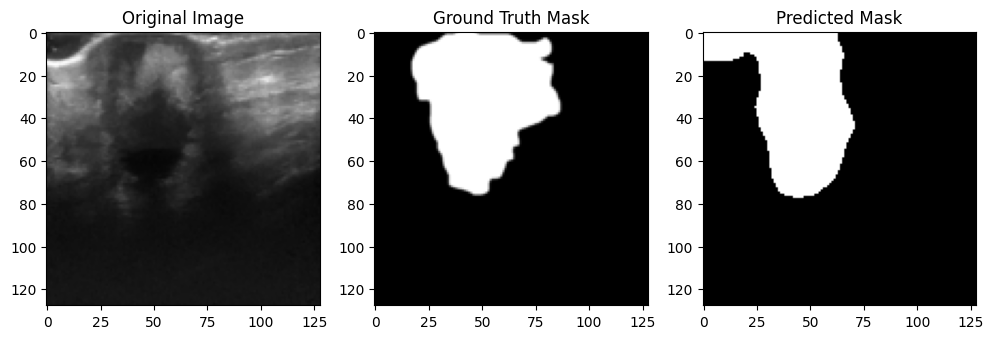

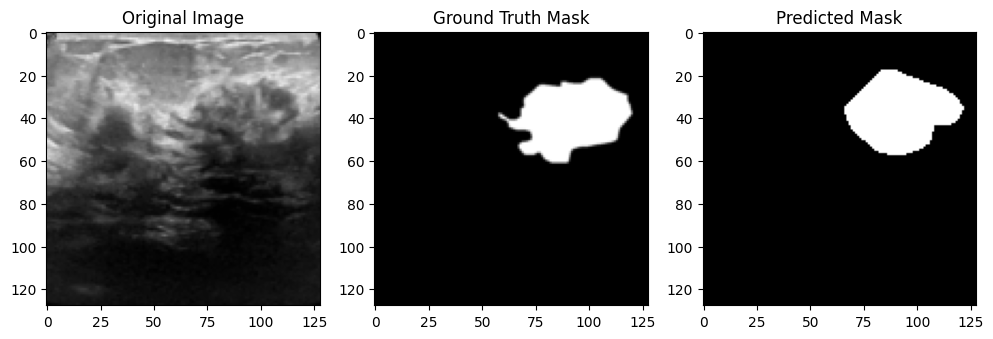

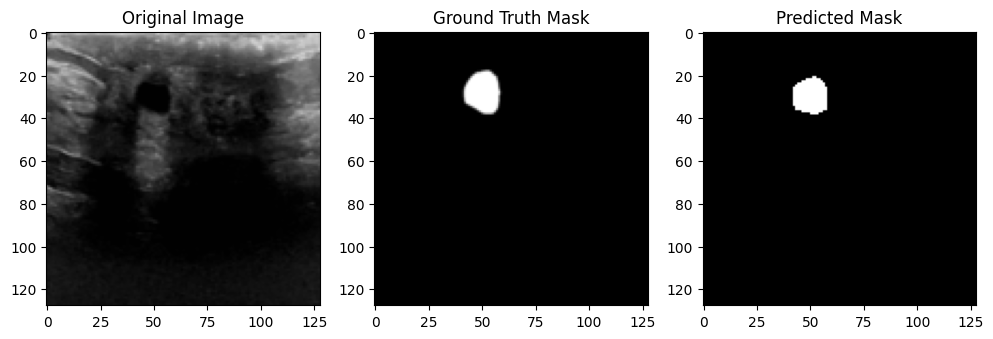

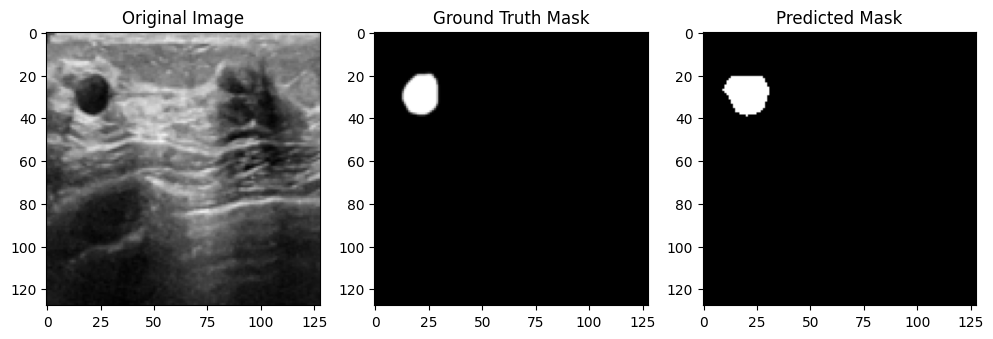

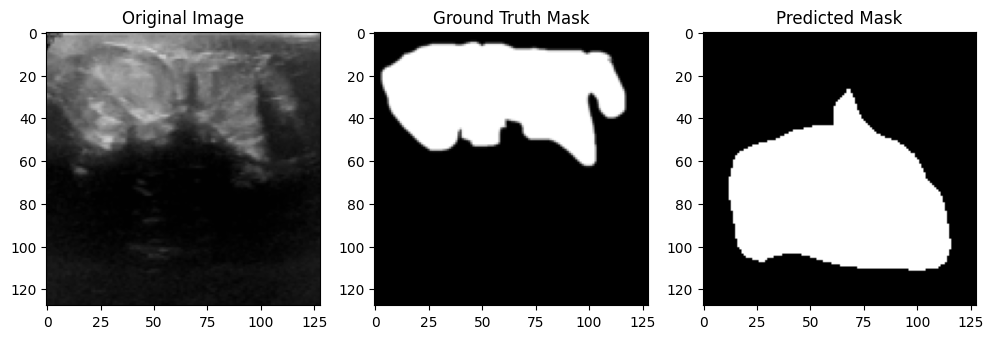

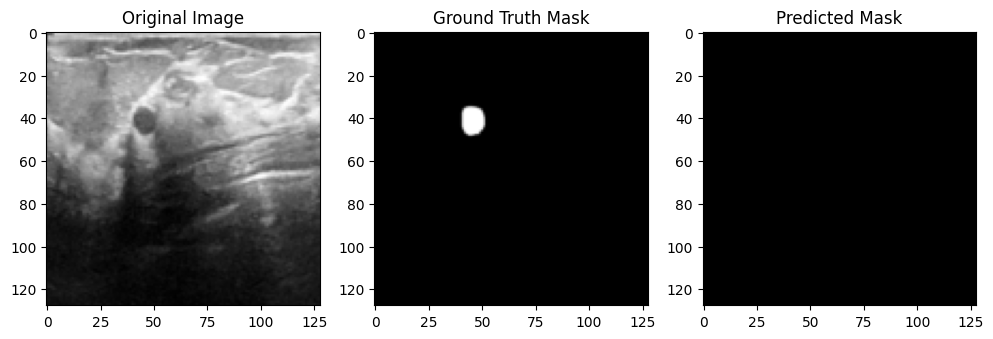

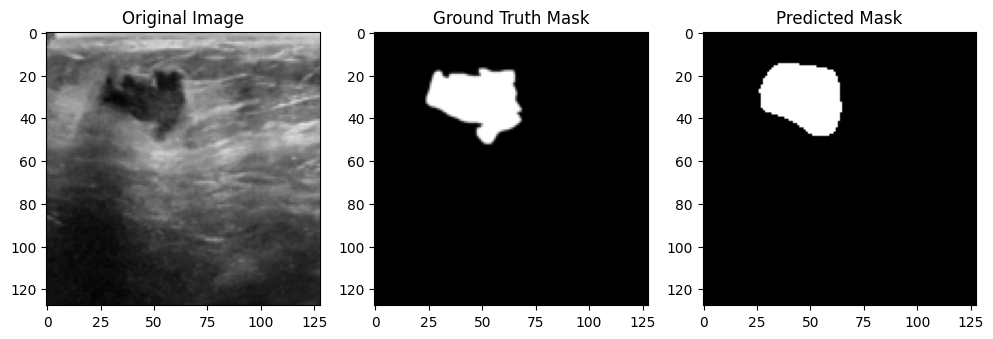

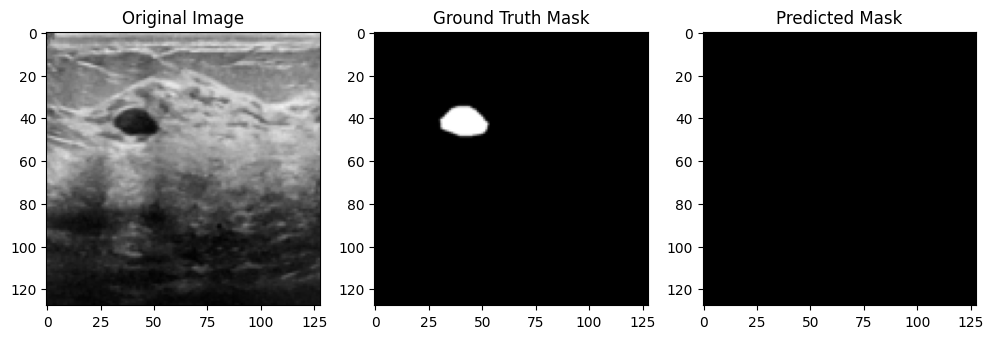

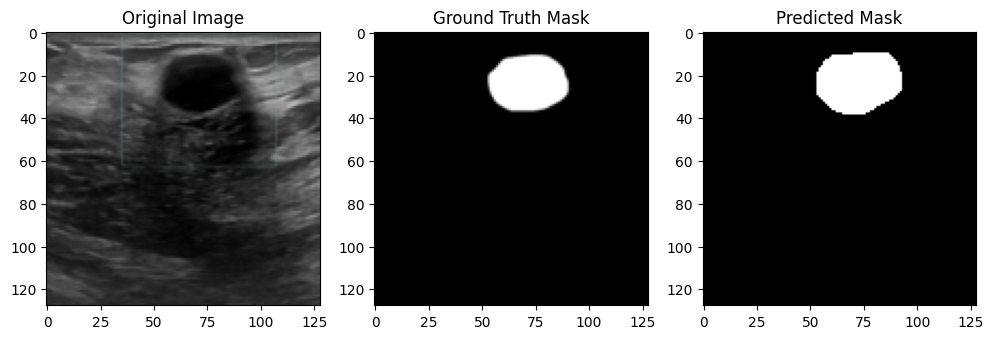

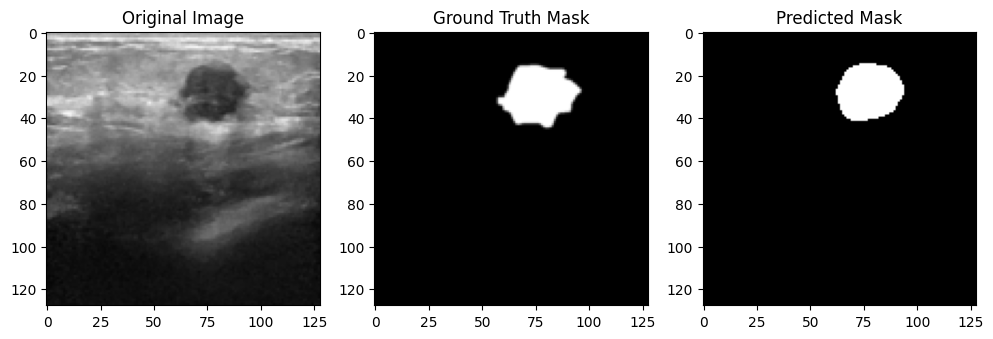

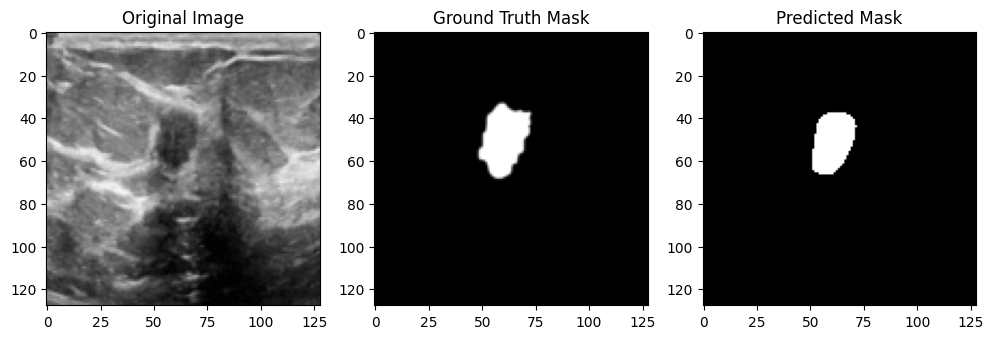

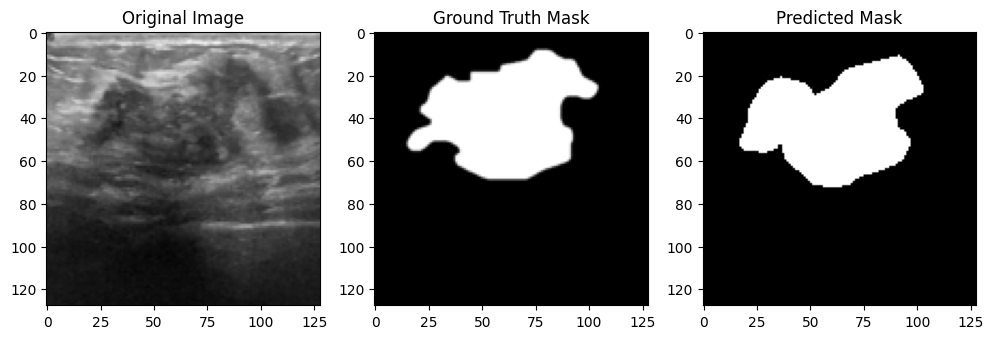

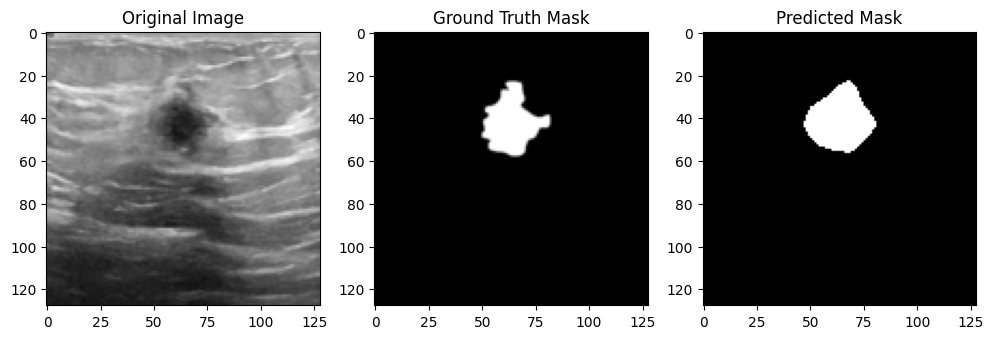

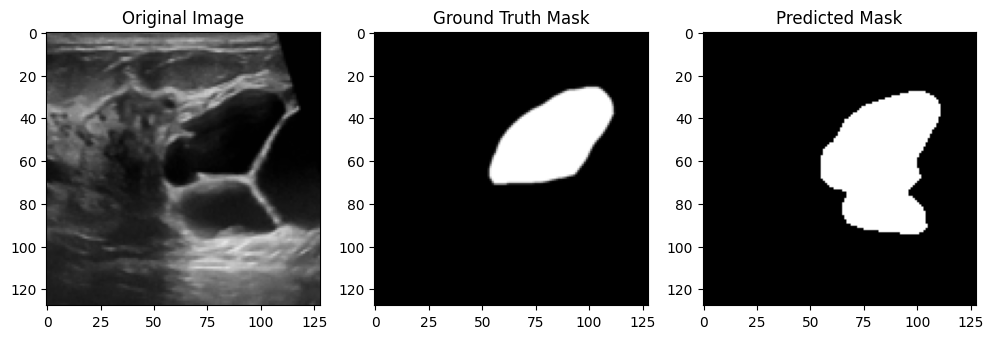

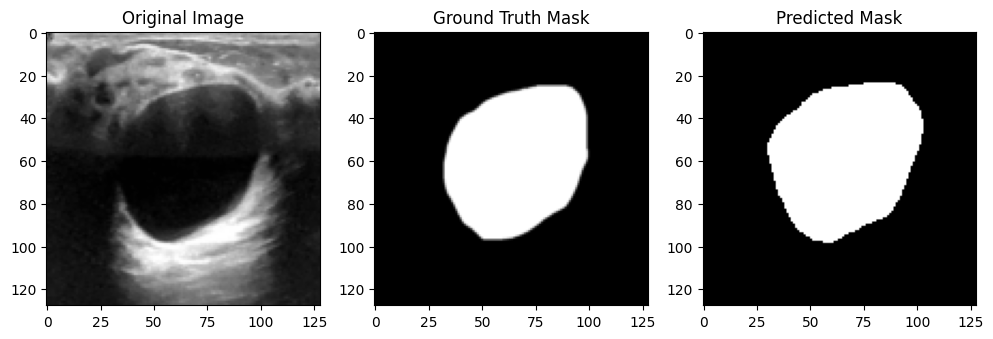

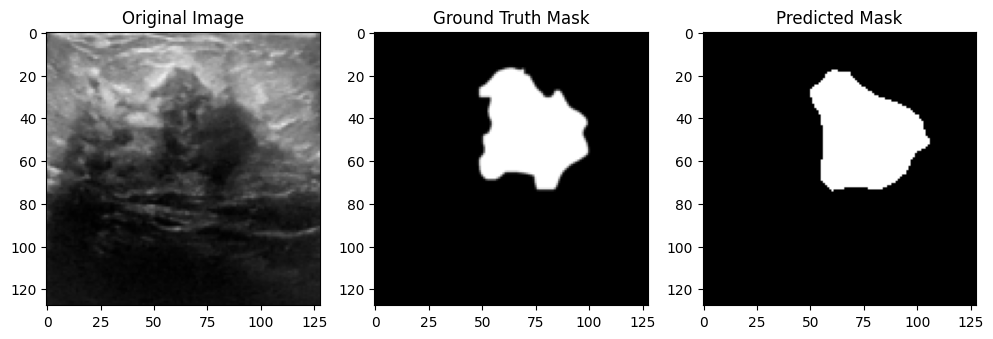

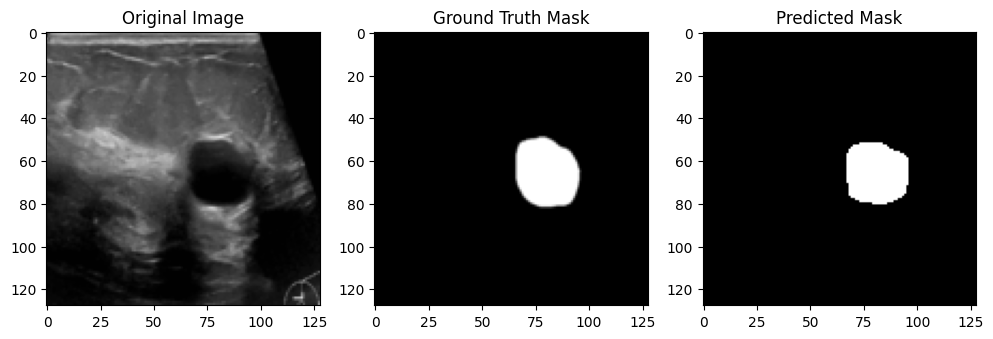

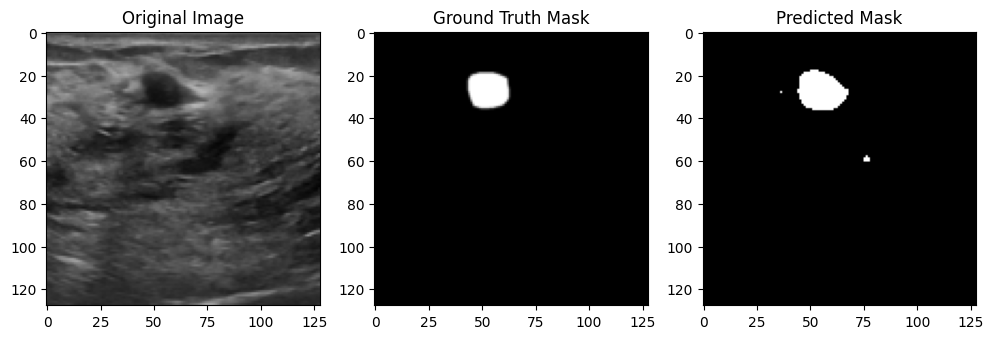

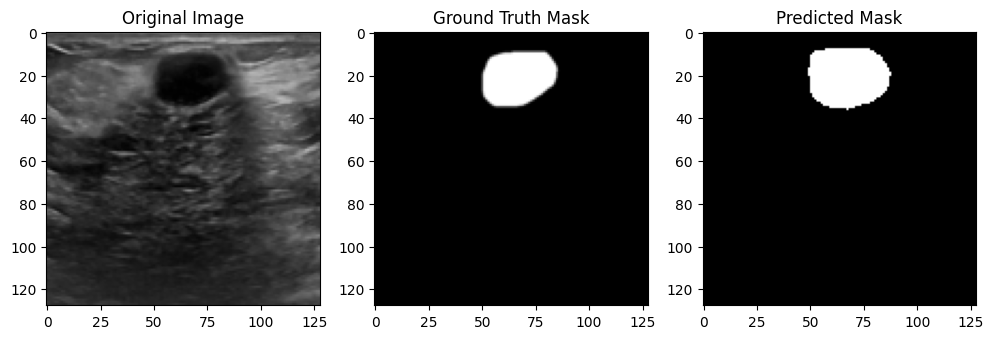

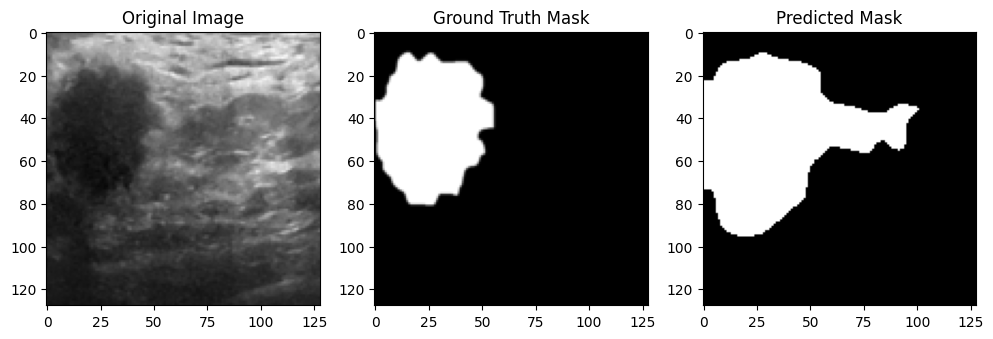

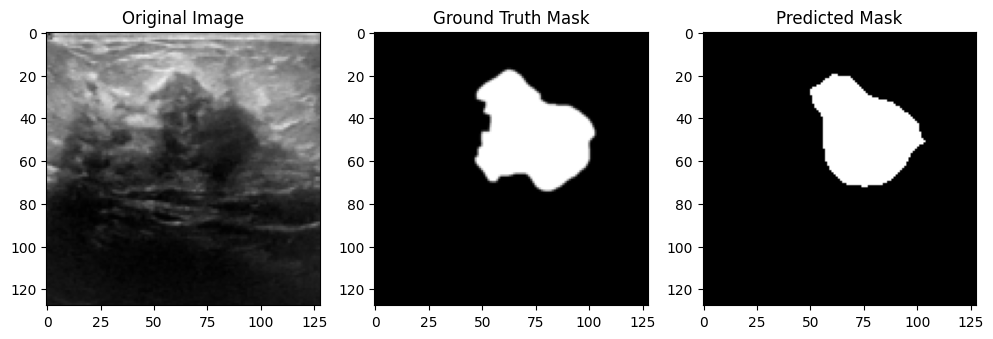

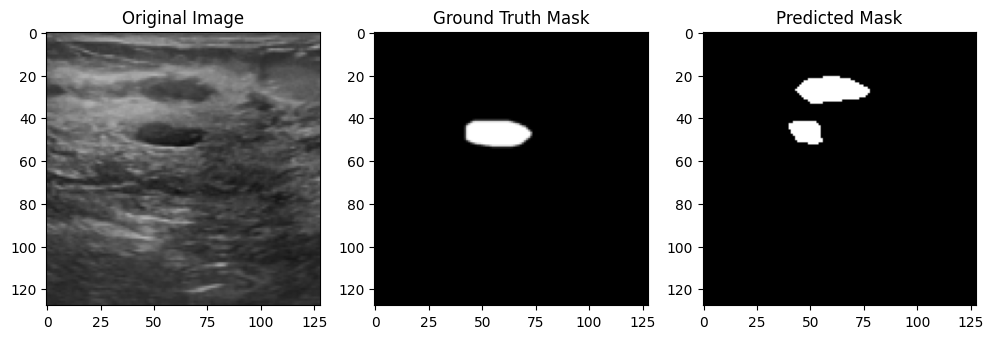

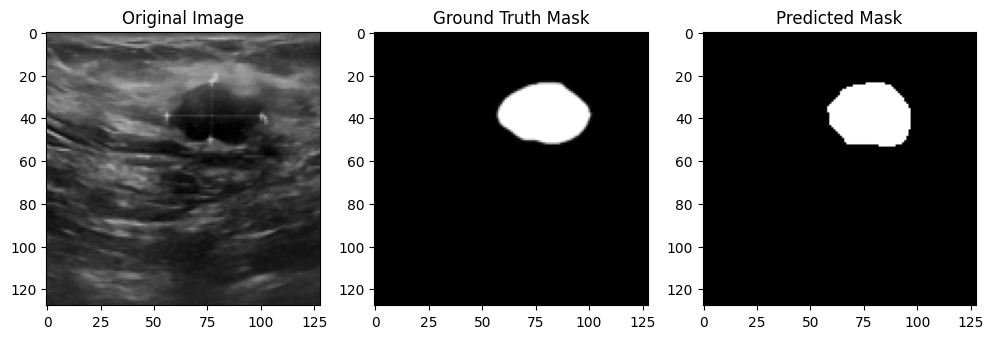

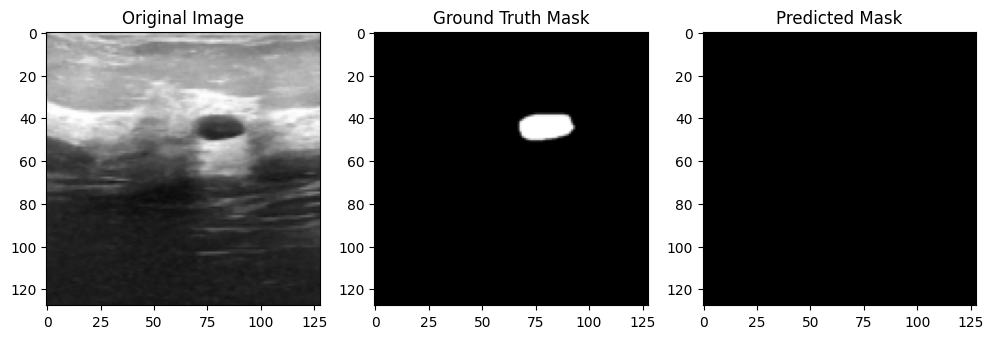

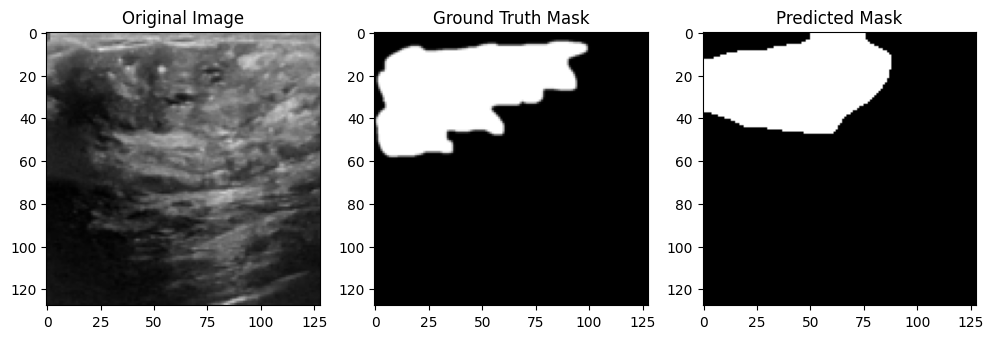

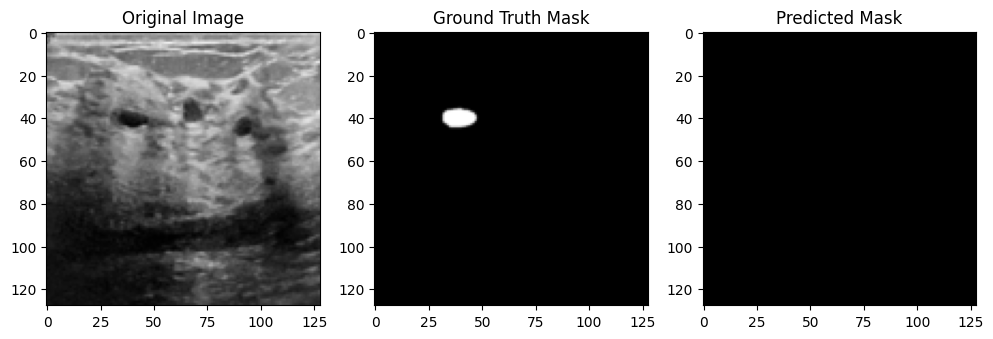

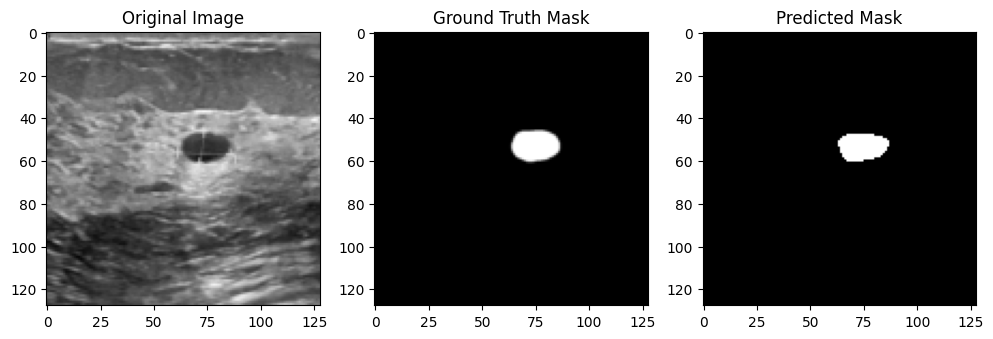

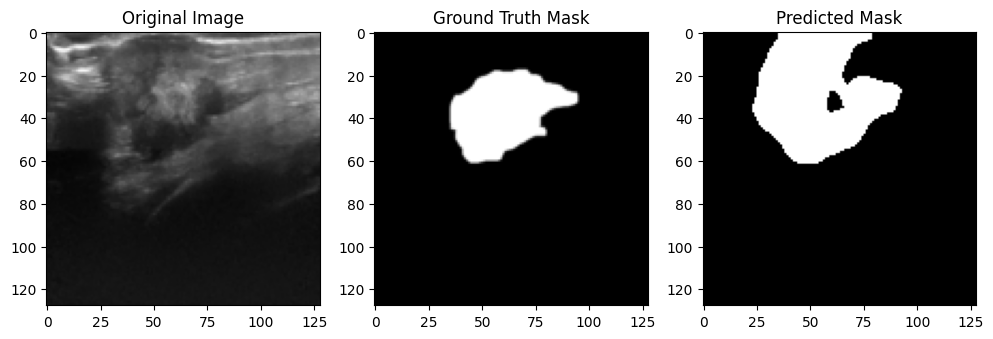

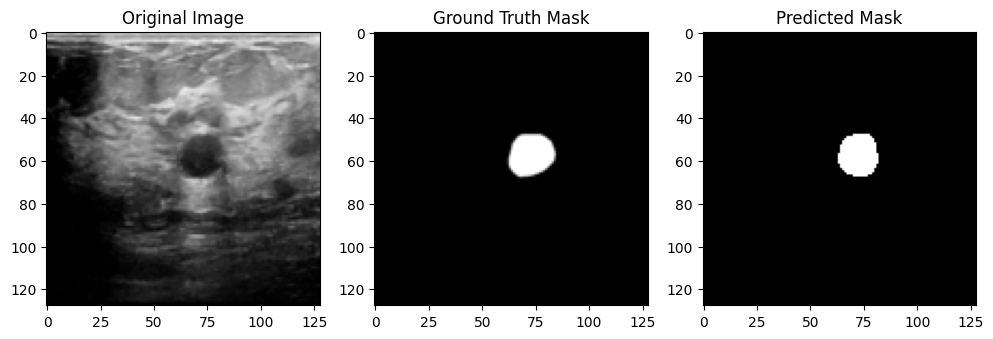

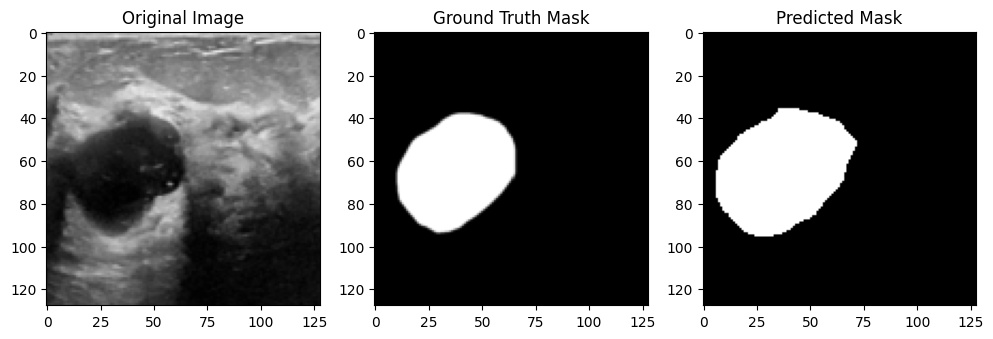

Test Results - Dice: 0.6864, IoU: 0.5977, Precision: 0.6825, Recall: 0.7388


In [13]:
import matplotlib.pyplot as plt

# Iterate through the test dataset
counter = 0
for images, masks in test_loader:
    with torch.no_grad():
        # Get model predictions
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]

        # Calculate the metrics using the defined functions
        test_dice += dice_coefficient(torch.sigmoid(outputs), masks)
        test_iou += iou(torch.sigmoid(outputs), masks)
        test_precision += precision(torch.sigmoid(outputs), masks)
        test_recall += recall(torch.sigmoid(outputs), masks)
        
                # For visualization of the first 30 images
        for i in range(len(images)):
            counter += 1
            if counter <= 30:
                # Get the predictions for the current image
                pred_masks = (torch.sigmoid(outputs[i]) > 0.5).float()

                # Plot original image, ground truth mask, and predicted mask
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
                axs[0].set_title('Original Image')

                axs[1].imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
                axs[1].set_title('Ground Truth Mask')

                axs[2].imshow(pred_masks.squeeze().cpu().numpy(), cmap='gray')
                axs[2].set_title('Predicted Mask')

                plt.show()
        

# Calculate the average metrics
num_samples = len(test_loader)
test_dice /= num_samples
test_iou /= num_samples
test_precision /= num_samples
test_recall /= num_samples

print(f"Test Results - Dice: {test_dice:.4f}, IoU: {test_iou:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
